**This notebook serves the purpose of clustering authors based on the ti-idf vector representations of their papers' abstract.**

**Resources consulted online**:
1. https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
2. https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval
3. https://stackoverflow.com/questions/4530611/saving-and-loading-objects-and-using-pickle

# Load modules

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

In [2]:
# Ignore warning messages (only) for display purpose
import warnings
warnings.filterwarnings('ignore')

# Prepare the dataset used for clustering

In [3]:
df = pd.read_csv('../database/preprocessed_content_analysis.csv', index_col=0)
df

,middle_name,last_name,email,institution,award_year,award_amount,paper_title,journal,publication_year,coauthors,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
first_name,,,,,,,,,,,,,,,,,,,,,
Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Effect of oxidation and geometrical dimensions...,Desalination,2011,"['amjad h el-sheikh', 'yahya s al-degs', ""rand...",...,13,5,10,5,7,1,"['Effect', 'of', 'oxidation', 'and', 'geometri...","['effect', 'oxidation', 'geometrical', 'dimens...","['This', 'study', 'reports', 'for', 'the', 'fi...","['study', 'report', 'time', 'use', 'oxidize', ..."
Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Synthesis and biological evaluation of new pyr...,Molecules,2014,"['ayman m saleh', 'randa m al-as’ ad', 'mustaf...",...,13,5,10,5,7,1,"['Synthesis', 'and', 'biological', 'evaluation...","['synthesis', 'biological', 'evaluation', 'new...","['A', 'selected', 'set', 'of', 'substituted', ...","['select', 'set', 'substituted', 'pyridone', '..."
Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...",Zeitschrift für Naturforschung B,2013,"['randa m al-as’ ad', 'mustafa m el-abadelah',...",...,13,5,10,5,7,1,"['Synthesis', 'of', '6', 'Ethyl-1', '2', '9', ...","['synthesis', 'ethyl-1', 'trioxopyrrolo', 'f',...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...",Z. Naturforsch,2013,['wolfgang voelterb'],...,13,5,10,5,7,1,"['Randa', 'M.', 'Al', 'As', 'ada', 'Mustafa', ...","['randa', 'm.', 'al', 'ada', 'mustafa', 'm.', ...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
Leaf,NaN,Van Boven,vanboven@colorado.edu,university of colorado at boulder,2011,250000,Identifiable but not identical: Combining soci...,Journal of Consumer research,2012,"['cindy chan', 'jonah berger', 'leaf van boven']",...,868,1234,1132,1198,1222,179,"['Identifiable', 'but', 'not', 'identical', 'C...","['identifiable', 'identical', 'combine', 'soci...","['How', 'do', 'consumers', 'reconcile', 'confl...","['consumer', 'reconcile', 'conflicting', 'moti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,Assessing the Impacts of Extreme Precipitation...,AGU Fall Meeting Abstracts,2020,"['charlotte cockburn', 'jonathan winter', 'eri...",...,453,500,457,549,582,101,"['Assessing', 'the', 'Impacts', 'of', 'Extreme...","['assess', 'impact', 'extreme', 'precipitation...","['Floods', 'have', 'a', 'devastating', 'impact...","['flood', 'devastating', 'impact', 'infrastruc..."
Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,What is Fluvial Geomorphic Equilibrium?: Evalu...,AGU Fall Meeting Abstracts,2019,"['jordan fields', 'frank j magilligan', 'carl ...",...,453,500,457,549,582,101,"['What', 'is', 'Fluvial', 'Geomorphic', 'Equil...","['fluvial', 'geomorphic', 'equilibrium', 'eval...","['Various', 'definitions', 'of', 'equilibrium'...","['definition', 'equilibrium', 'alluvial', 'cha..."
Francis,J,Magilligan,francis.j.magilligan@dartmouth.edu,dartmouth college,2020,427479,Bankfull Channel Adjustments to Episodic and L...,AGU Fall Meeting Abstracts,2019,"['frank j magilligan', 'carl e renshaw', 'evan...",...,453,500,457,549,582,101,"['Bankfull', 'Channel', 'Adjustments', 'to', '...","['bankfull', 'channel', 'adjustment', 'episodi...","['The', 'bankfull', 'Shields', 'value', 'is', ...","['bankfull', 'shield', 'value', 'increasingly'..."


In [4]:
# prepare data for clustering
df['normalized_abstract'] = df['normalized_abstract'].apply(ast.literal_eval)
df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: ' '.join(x))

In [5]:
# group by email and concatenate abstracts
cluster_df = df.groupby('email')['normalized_abstract'].apply(lambda x: '. '.join(x)).reset_index()

# Perform clustering

In [6]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate a sparse TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix = tfidf_matrix.toarray()

In [7]:
# fit SVD
n_components = min(tfidf_matrix.shape) - 1
pca = PCA(n_components=n_components)
pca.fit(tfidf_matrix)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

526

In [8]:
# fit and transform TF-IDF matrix
pca = PCA(n_components=526)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix)

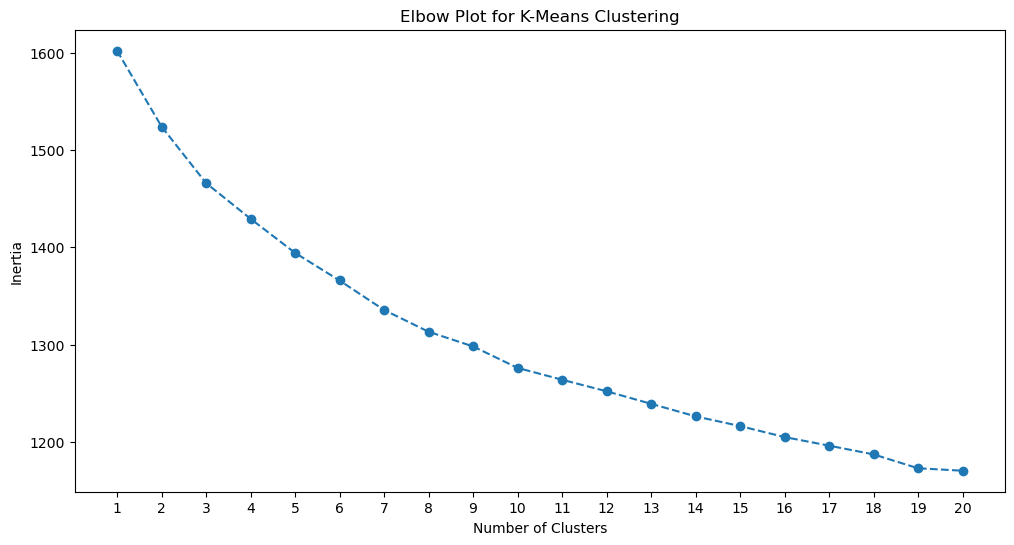

In [9]:
# calculate the inertia for each number of clusters
num_clusters = range(1, 21)
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_reduced)
    inertias.append(kmeans.inertia_)

# plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(num_clusters)
plt.show()

In [10]:
# perform K-means clustering on the reduced TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=8, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_reduced)

# add cluster labels to the dataframe
cluster_df['tfidf_cluster'] = kmeans_tfidf.labels_

In [11]:
# function to find the most distinctive words in each cluster
def find_distinctive_words_by_cluster(clusters):
    aggregate_tfidf_vectors_by_cluster = {}
    
    for i, cluster in enumerate(clusters):
        if cluster not in aggregate_tfidf_vectors_by_cluster:
            aggregate_tfidf_vectors_by_cluster[cluster] = tfidf_matrix[i]
        else:
            aggregate_tfidf_vectors_by_cluster[cluster] += tfidf_matrix[i]

    distinctive_words_by_cluster = {}
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for cluster, agg_tfidf in aggregate_tfidf_vectors_by_cluster.items():
        sorted_indices = np.argsort(agg_tfidf).flatten()[::-1]
        distinctive_words_by_cluster[cluster] = feature_names[sorted_indices][:20]

    for cluster, words in distinctive_words_by_cluster.items():
        print(f"Cluster {cluster}: {words}")

In [12]:
# find the most distinctive words in each TF-IDF cluster
find_distinctive_words_by_cluster(cluster_df['tfidf_cluster'])

Cluster 0: ['language' 'word' 'linguistic' 'speaker' 'speech' 'english' 'sentence'
 'child' 'verb' 'syntactic' 'vowel' 'semantic' 'study' 'listener'
 'lexical' 'l2' 'phonological' 'grammar' 'experiment' 'learner']
Cluster 3: ['visual' 'memory' 'task' 'brain' 'neural' 'stimulus' 'object' 'study'
 'model' 'participant' 'cortex' 'cognitive' 'control' 'human' 'experiment'
 'response' 'learn' 'information' 'network' 'performance']
Cluster 7: ['child' 'study' 'social' 'self' 'emotion' 'participant' 'behavior'
 'research' 'woman' 'people' 'health' 'group' 'individual' 'infant'
 'examine' 'effect' 'high' 'adolescent' 'relationship' 'result']
Cluster 4: ['de' 'la' 'en' 'el' 'que' 'los' 'las' 'del' 'se' 'archaeological'
 'social' 'political' 'study' 'site' 'land' 'economic' 'human' 'community'
 'et' 'change']
Cluster 5: ['archaeological' 'site' 'archaeology' 'human' 'early' 'settlement'
 'study' 'ancient' 'archaeologist' 'datum' 'period' 'date' 'analysis'
 'excavation' 'stone' 'island' 'region' 

In [13]:
# create a cluster mapping
tfidf_cluster_mapping = {
    0: 'Cultural Studies',
    1: 'Phonetics',
    2: 'Psychology',
    3: 'Linguistics',
    4: 'Environmental Studies',
    5: 'Human Biology',
    6: 'Archaeology',
    7: 'Cognitive Neuroscience',
}

# apply the mapping to TF-IDF clusters
cluster_df['tfidf_cluster'] = cluster_df['tfidf_cluster'].map(tfidf_cluster_mapping)

In [14]:
# initiate a TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate TF-IDF matrix in sparse format
tfidf_matrix_sparse = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix_dense = tfidf_matrix_sparse.toarray()

# reduce the TF-IDF matrix to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_matrix_2D = pca.fit_transform(tfidf_matrix_dense)

# apply k-means clustering on the reduced data
kmeans_tfidf = KMeans(n_clusters=8, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_2D)

KMeans(random_state=42)

In [15]:
# Save `cluster_df` for later descriptive and visualization
cluster_df.to_csv("../database/author_clustering/cluster_df.csv", index=False)

In [16]:
# Save `tfidf_matrix_2D`, `tfidf_cluster_mapping`, and `kmeans_tfidf` for later descriptive and visualization
with open('../database/author_clustering/tfidf_matrix_2D.pkl', 'wb') as file:
    pickle.dump(tfidf_matrix_2D, file)

with open('../database/author_clustering/tfidf_cluster_mapping.pkl', 'wb') as file:
    pickle.dump(tfidf_cluster_mapping, file)

with open('../database/author_clustering/kmeans_tfidf.pkl', 'wb') as file:
    pickle.dump(kmeans_tfidf, file)